# `DiffusionCrankNic.m`

In [3]:
function [x, err] = TriDiagonal(a, b, c, f)
    % Solution of a linear system of equations with a tridiagonal
    % matrix.
    %
    %   a(k) x(k-1) + b(k) x(k) + c(k) x(k+1) = f(k)
    %
    % with a(1) = c(n) = 0.
    %
    % Input
    %   a(1:n), b(1:n), c(1:n) : the coefficients of the system
    %                            matrix
    %   f(1:n) : the right hand side vector
    %
    % Output
    %   x(1:n) : the solution to the linear system of equations, if
    %            no division by zero occurs
    %   err : = 0, if no division by zero occurs
    %         = 1, if division by zero is encountered
    n = length(f);
    alpha = zeros(n, 1);
    beta = zeros(n, 1);
    err = 0;

    if abs(b(1)) > eps(b(1))
        alpha(1) = -c(1) / b(1);
        beta(1) = f(1) / b(1);
    else
        err = 1;
        return;
    end

    for k = 2:n
        denominator = a(k) * alpha(k - 1) + b(k);

        if abs(denominator) > eps(denominator)
            alpha(k) =- c(k) / denominator;
            beta(k) = (f(k) - a(k) * beta(k - 1)) / denominator;
        else
            err = 1;
            return;
        end

    end

    if abs(a(n) * alpha(n - 1) + b(n)) > eps(b(n))
        x(n) = (f(n) - a(n) * beta(n - 1)) / (a(n) * alpha(n - 1) + b(n));
    else
        err = 1;
        return;
    end

    for k = n - 1:-1:1
        x(k) = alpha(k) * x(k + 1) + beta(k);
    end

end

In [5]:
function frc = fForcing(N, t)
    %
    % Constructs the forcing term:
    %
    % Input
    %   N : to compute the mesh size
    %   t : the current time at the time interval midpoint
    %
    % Output
    %   f(1:N-1) : the array of values of the forcing function
    %
    frc = zeros(1, N - 1);
    h = 1.0 / N;

    for i = 1:N - 1
        x = i * h;
        tpx = 2.0 * pi * x;
        tpt = 2.0 * pi * t;
        frc(i) = 2.0 * pi * sin(tpt) * (1.0 - exp(sin(tpx))) ...
            + 4.0 * pi * pi * cos(tpt) * exp(sin(tpx)) ...
            * (sin(tpx) - cos(tpx) * cos(tpx));
    end

end

In [6]:
function ue = uExact(N, t)
    %
    % Constructs the exact solution:
    %
    % Input
    %   N : to compute the mesh size
    %   t : the current time
    %
    % Output
    %   ue(1:N+1) : the array of values of the exact solution
    %
    ue = zeros(1, N + 1);
    h = 1.0 / N;

    for i = 0:N
        x = i * h;
        tpx = 2.0 * pi * x;
        tpt = 2.0 * pi * t;
        ue(i + 1) = cos(tpt) * (exp(sin(tpx)) - 1.0);
    end

end

In [10]:
function [error] = DiffusionCrankNic(finalT, N, K, numPlots)
    %
    % This function computes numerical approximations to solutions
    % of the linear diffusion equation
    %
    % u_t - u_xx = f(x,t)
    %
    % using the Crank-Nicolson (CN) method on the domain [0,1]. The
    % forcing function, f, and the intial conditions are constructed
    % so that the true solution is
    %
    % u(x,t) = cos(2*pi*t)*(exp(sin(2*pi*x))-1.0).
    %
    % This can be easily modified.
    %
    % Input
    %   finalT : the final time
    %   N : the number of spatial grid points in [0,1]
    %   K : the number of time steps in the interval [0,finalT]
    %   numPlots : the number of output frames in the time interval
    %              [0,finalT]. numPlots must be a divisor of K.
    %
    % Output
    %   error: the max norm error of the CN scheme at t = finalT
    %
    error = 0.0;

    if N > 0 && N - floor(N) == 0
        h = 1.0 / N;
    else
        display('Error: N must be a positive integer.')
        return
    end

    if (K > 0 && K - floor(K) == 0) && finalT > 0
        tau = finalT / K;
    else
        display('Error: K must be a positive integer, and')
        display('       finalT must be positive.')
        return
    end

    mu = tau / (2.0 * h * h);

    x = 0:h:1.0;
    uoCN(1:N + 1) = uExact(N, 0.0);

    if mod(K, numPlots) == 0
        stepsPerPlot = K / numPlots;
    else
        display('Error: numPlots is not a divisor of K.')
        return
    end

    %
    % Define the tridiagonal system matrix to be inverted:
    %
    a(1) = 0.0;
    a(2:N - 1) = -mu;
    b(1:N - 1) = 1.0 + 2.0 * mu;
    c(1:N - 2) = -mu;
    c(N - 1) = 0.0;
    %
    % Main time loop:
    %
    for k = 1:numPlots

        for j = 1:stepsPerPlot
            kk = (k - 1) * stepsPerPlot + j;
            currTime = tau * (kk);
            lastTime = tau * (kk - 1.0);
            f(1:N - 1) = tau * (fForcing(N, currTime) ...
                +fForcing(N, lastTime)) / 2.0;

            for ell = 1:N - 1
                rhs(ell) = f(ell) + uoCN(ell + 1) + mu * (uoCN(ell) ...
                    -2.0 * uoCN(ell + 1) + uoCN(ell + 2));
            end

            [uCN(2:N), err] = TriDiagonal(a, b, c, rhs);
            uCN(1) = 0.0;
            uCN(N + 1) = 0.0;
            uoCN = uCN;
        end

        hf = figure(k);
        clf
        plot(x, uExact(N, currTime), 'k-', x, uCN, 'b-o')
        grid on,
        xlabel("x");
        ylabel('exact and approximate solutions');
        title(['Crank--Nicolson Approximation at T = ', ...
                num2str(currTime), ', h = ', num2str(h), ...
                ', and tau =', num2str(tau)]);
        legend("Exact", "Crank--Nicolson")
        set(gca, "xTick", 0:0.1:1)

        s1 = ['000', num2str(k)];
        s2 = s1((length(s1) - 3):length(s1));
        s3 = ['OUT/diff', s2, '.pdf'];
        %exportgraphics(gca, s3)
    end

    error = max(abs(uExact(N, currTime) - uCN));
end

In [17]:
finalT = 10;
N = 100;
K = 50;
numPlots = 25;


error = 0.019031


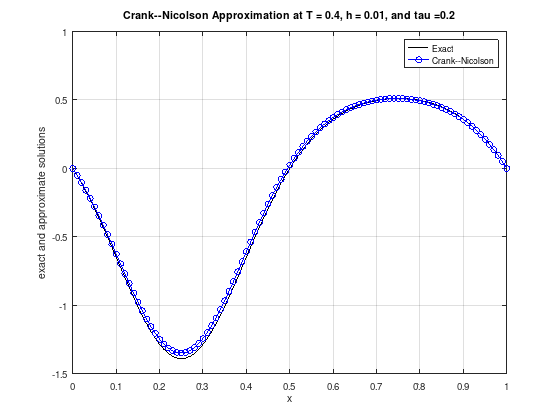

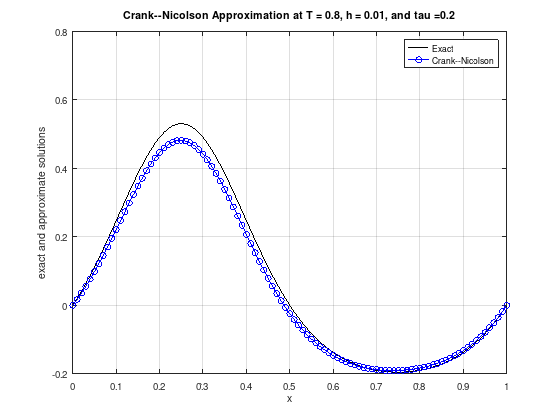

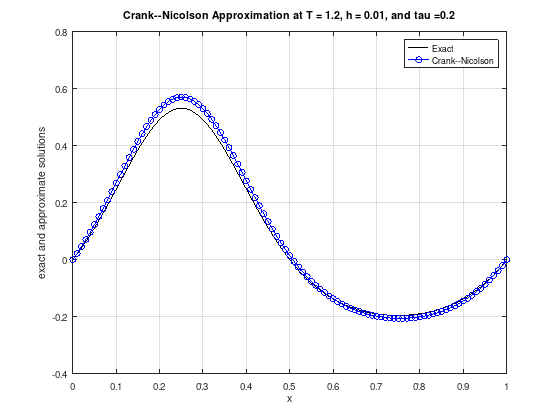

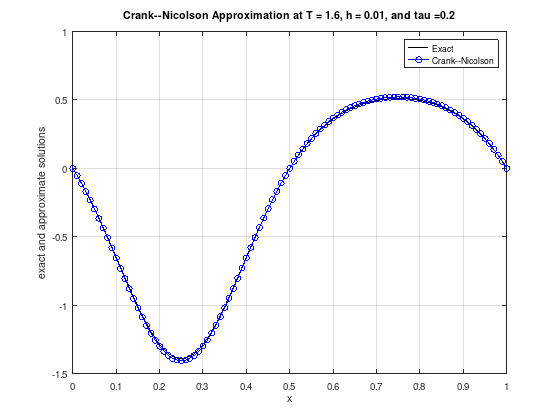

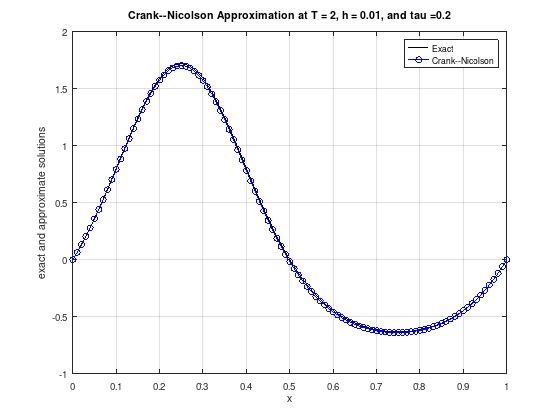

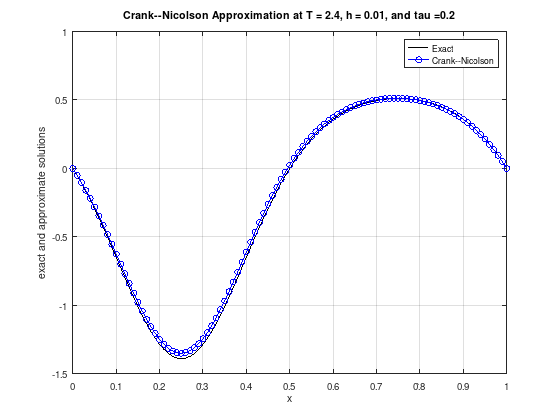

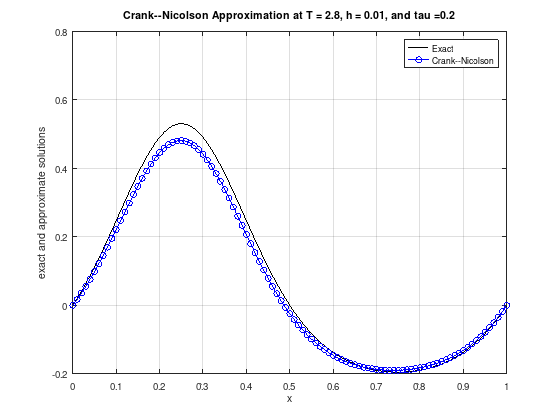

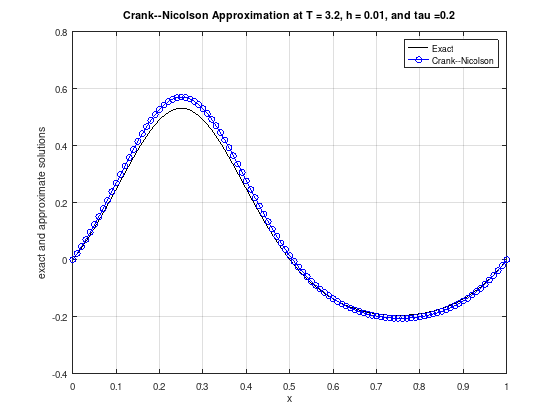

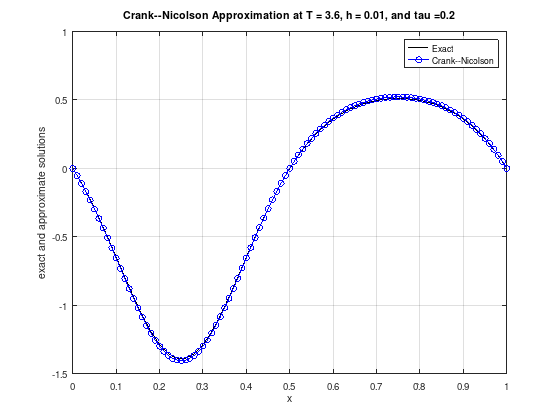

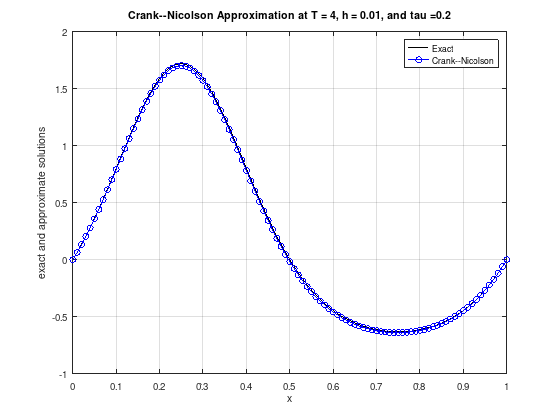

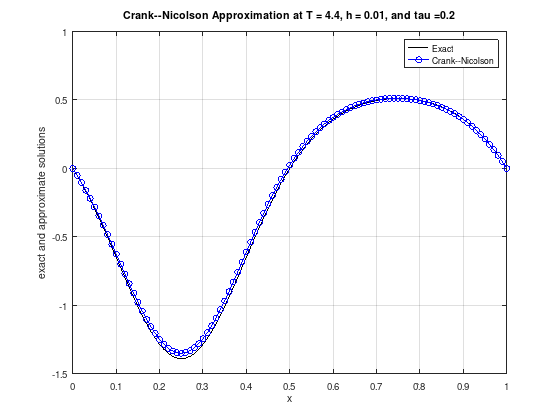

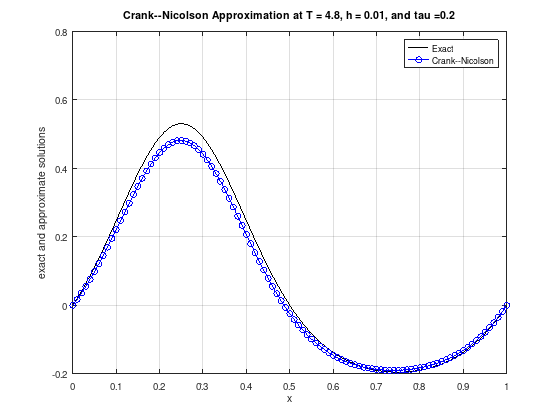

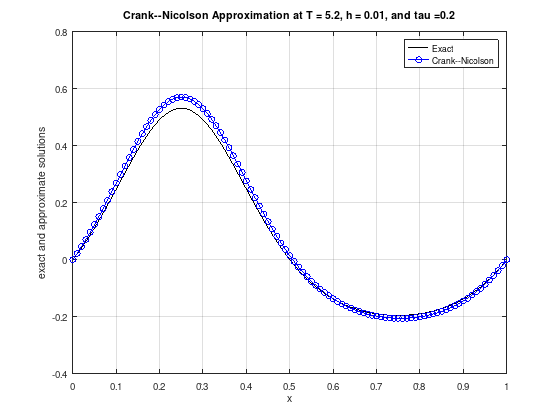

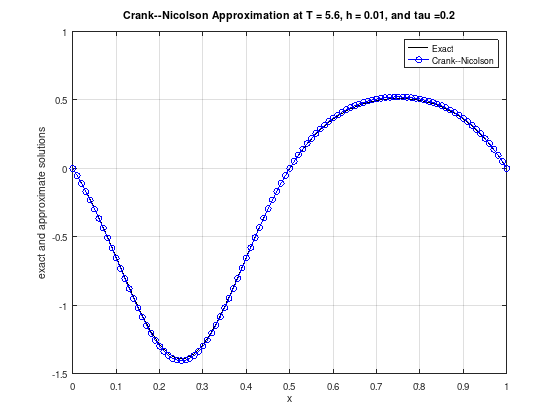

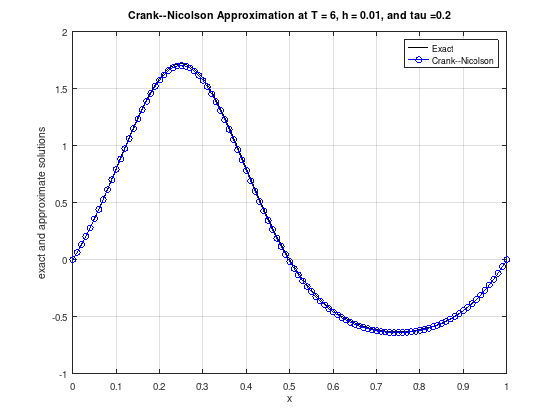

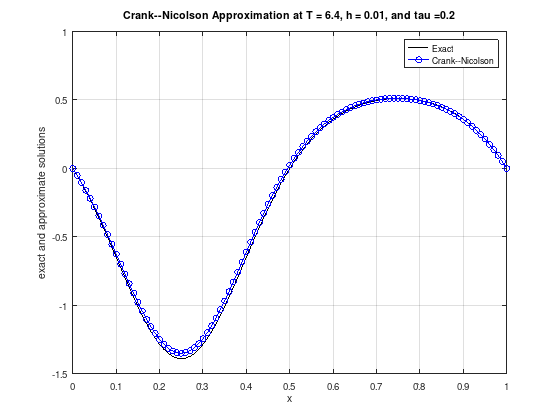

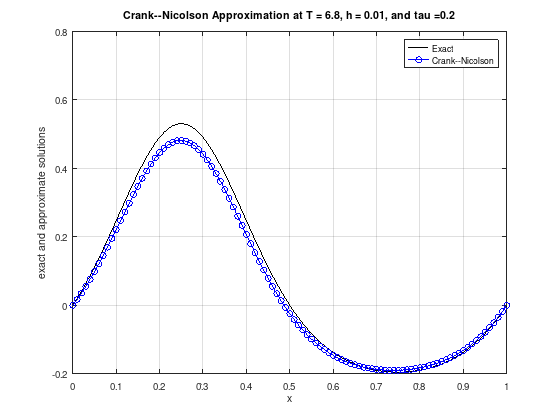

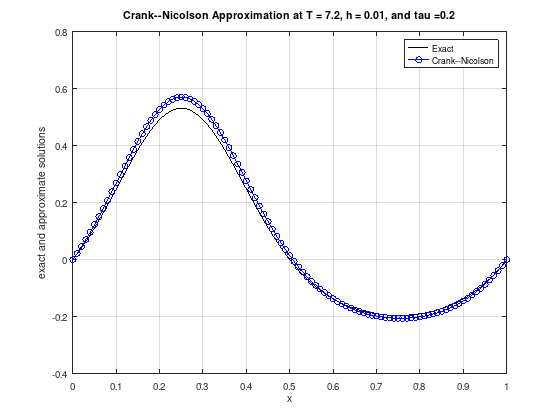

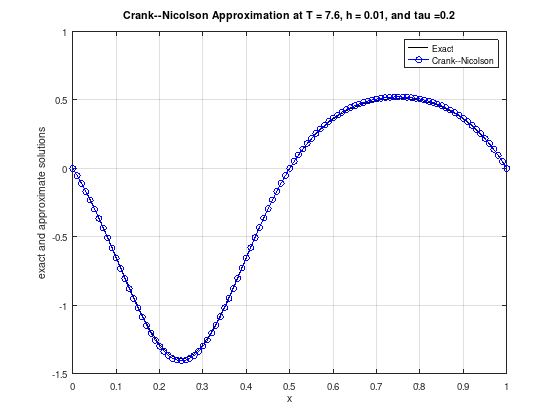

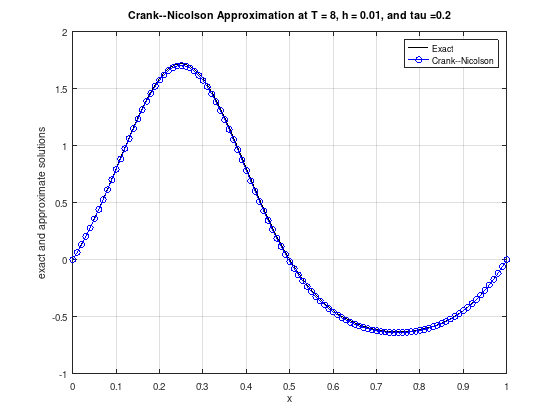

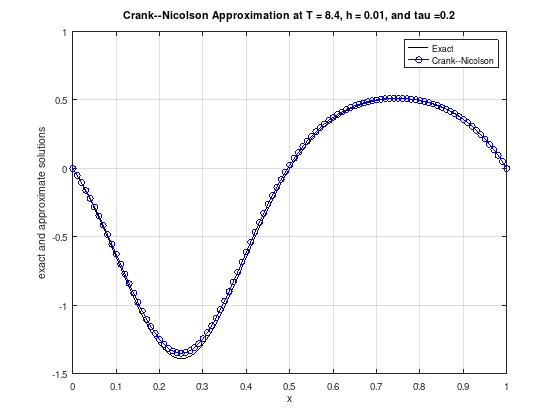

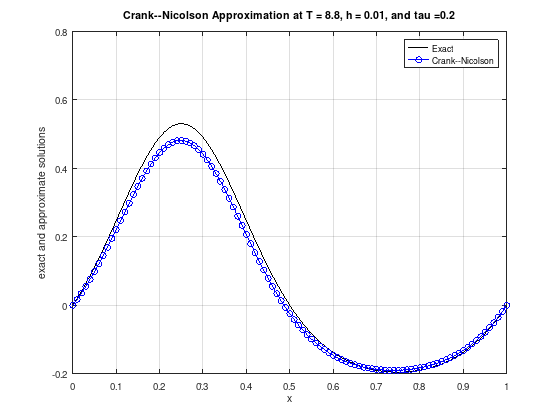

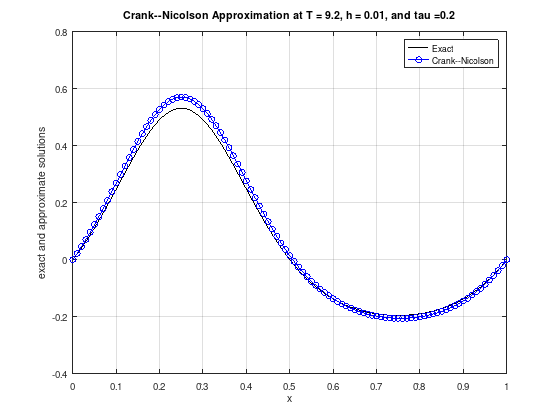

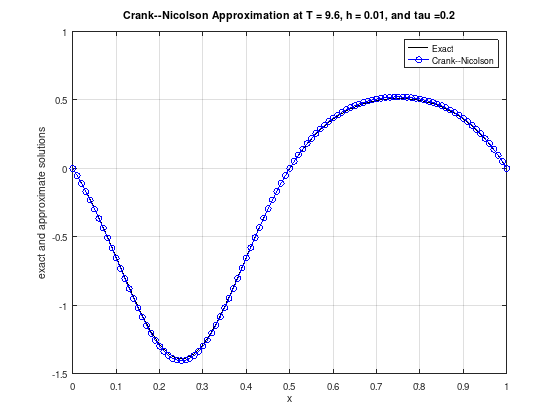

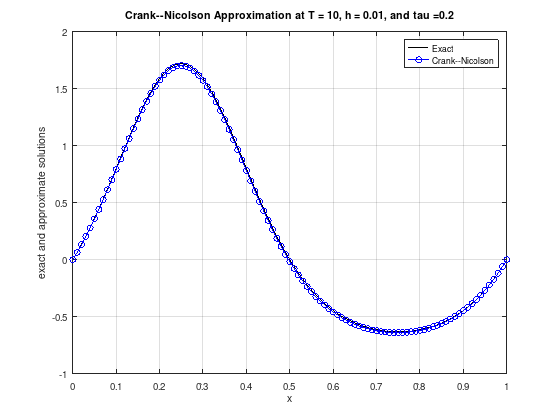

In [18]:
[error] = DiffusionCrankNic(finalT, N, K, numPlots)